# Custom datasets

In [2]:
import os
import torch
import torchvision
import torch.nn.functional as F
from collections import defaultdict
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
from pathlib import Path
from PIL import Image
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
  print(f"{image_path}")
else:
  print("The directory doesn't exist. Creating a new one. ")
  image_path.mkdir(parents = True, exist_ok = True)
  with open(data_path / "pizza_steak_sushi.zip", "wb") as file:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    file.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip:
    print("Unzipping pizza, steak, sushi data...")
    zip.extractall(image_path)
print("Dataset has been installed!")

The directory doesn't exist. Creating a new one. 
Unzipping pizza, steak, sushi data...
Dataset has been installed!


In [5]:
def walk_through_dir(directory: str) -> None:
  for dir_path, dir_name, filenames in os.walk("/content/data/pizza_steak_sushi"):
    if len(filenames)!=0:
      print(f"There are {len(filenames)} images in '{dir_path}'.")

In [6]:
walk_through_dir("/content/data/pizza_steak_sushi/")
train_dir = image_path / "train"
test_dir = image_path / "test"

There are 72 images in '/content/data/pizza_steak_sushi/train/sushi'.
There are 75 images in '/content/data/pizza_steak_sushi/train/steak'.
There are 78 images in '/content/data/pizza_steak_sushi/train/pizza'.
There are 31 images in '/content/data/pizza_steak_sushi/test/sushi'.
There are 19 images in '/content/data/pizza_steak_sushi/test/steak'.
There are 25 images in '/content/data/pizza_steak_sushi/test/pizza'.


In [7]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
train_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() # / 255.
])
test_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor() # / 255.
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform)

In [11]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)

Text(0.5, 1.0, 'pizza')

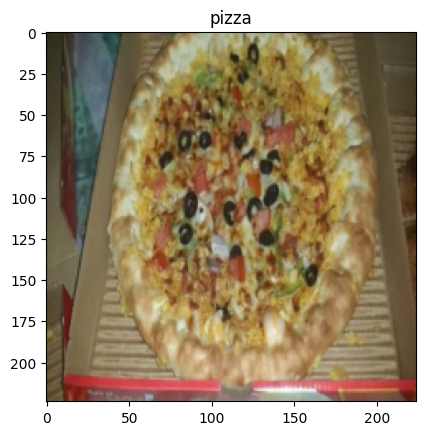

In [10]:
img, label = next(iter(train_dataloader))
plt.imshow(img.squeeze().permute(1,2,0))
plt.title(train_data.classes[label])

In [112]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, # img size
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [129]:
model = TinyVGG(input_shape = 3,
                hidden_units = 36,
                output_shape = 3).to(device)
summary(model, input_size = [8, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [8, 3]                    --
├─Sequential: 1-1                        [8, 36, 32, 32]           --
│    └─Conv2d: 2-1                       [8, 36, 64, 64]           1,008
│    └─ReLU: 2-2                         [8, 36, 64, 64]           --
│    └─Conv2d: 2-3                       [8, 36, 64, 64]           11,700
│    └─ReLU: 2-4                         [8, 36, 64, 64]           --
│    └─MaxPool2d: 2-5                    [8, 36, 32, 32]           --
├─Sequential: 1-2                        [8, 36, 16, 16]           --
│    └─Conv2d: 2-6                       [8, 36, 32, 32]           11,700
│    └─ReLU: 2-7                         [8, 36, 32, 32]           --
│    └─Conv2d: 2-8                       [8, 36, 32, 32]           11,700
│    └─ReLU: 2-9                         [8, 36, 32, 32]           --
│    └─MaxPool2d: 2-10                   [8, 36, 16, 16]           --


In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [133]:
epochs = 20
model_score = defaultdict(list)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model = model,
             dataloader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer)
  test_loss, test_acc = test_step(model = model,
             dataloader = test_dataloader,
             loss_fn = loss_fn)
  model_score["train_loss"].append(train_loss)
  model_score["train_acc"].append(train_acc)
  model_score["test_loss"].append(test_loss)
  model_score["test_acc"].append(test_acc)

100%|██████████| 20/20 [01:54<00:00,  5.70s/it]


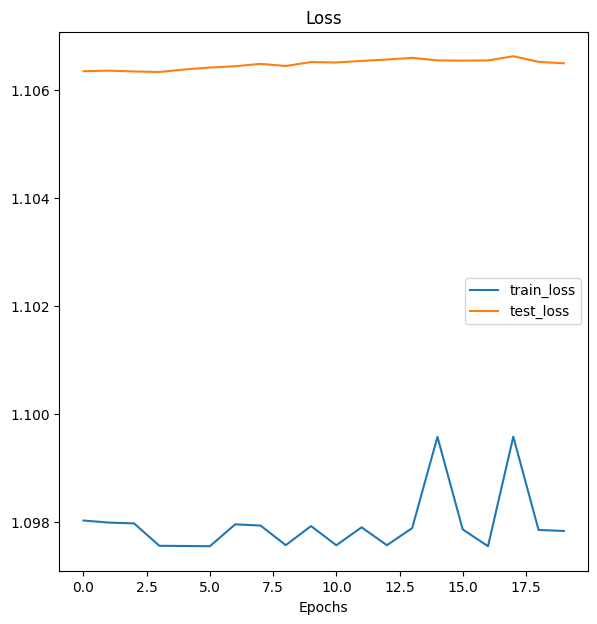

In [134]:
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), model_score["train_loss"], label = "train_loss")
plt.plot(range(epochs), model_score["test_loss"], label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

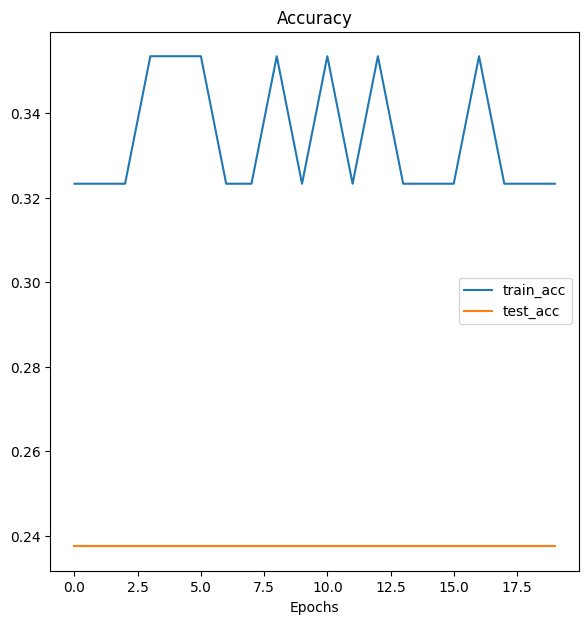

In [135]:
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), model_score["train_acc"], label = "train_acc")
plt.plot(range(epochs), model_score["test_acc"], label = "test_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

After a lot of experiments with TinyVGG model one may notice that this model is not capable to handle the task, so let's just use VGG-16 net.

In [13]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 3)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [14]:
model1 = VGG16_NET()
summary(model1, input_size = [32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
VGG16_NET                                [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 224, 224]        1,792
├─Conv2d: 1-2                            [32, 64, 224, 224]        36,928
├─MaxPool2d: 1-3                         [32, 64, 112, 112]        --
├─Conv2d: 1-4                            [32, 128, 112, 112]       73,856
├─Conv2d: 1-5                            [32, 128, 112, 112]       147,584
├─MaxPool2d: 1-6                         [32, 128, 56, 56]         --
├─Conv2d: 1-7                            [32, 256, 56, 56]         295,168
├─Conv2d: 1-8                            [32, 256, 56, 56]         590,080
├─Conv2d: 1-9                            [32, 256, 56, 56]         590,080
├─MaxPool2d: 1-10                        [32, 256, 28, 28]         --
├─Conv2d: 1-11                           [32, 512, 28, 28]         1,180,160
├─Conv2d: 1-12                           [32, 5

In [15]:
epochs = 20
new_model_score = defaultdict(list)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.1, weight_decay = 0.01)
for epoch in tqdm(range(epochs)):
  with torch.autograd.set_detect_anomaly(True):
    train_loss, train_acc = train_step(model = model1,
              dataloader = train_dataloader,
              loss_fn = loss_fn,
              optimizer = optimizer)
  test_loss, test_acc = test_step(model = model1,
             dataloader = test_dataloader,
             loss_fn = loss_fn)
  new_model_score["train_acc"].append(train_acc)
  new_model_score["train_loss"].append(train_loss)
  new_model_score["test_loss"].append(test_loss)
  new_model_score["test_acc"].append(test_acc)

100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


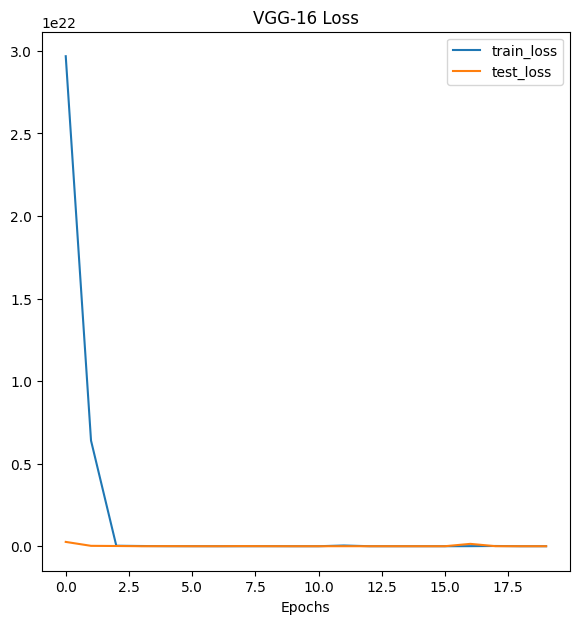

In [16]:
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), new_model_score["train_loss"], label = "train_loss")
plt.plot(range(epochs), new_model_score["test_loss"], label = "test_loss")
plt.title("VGG-16 Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

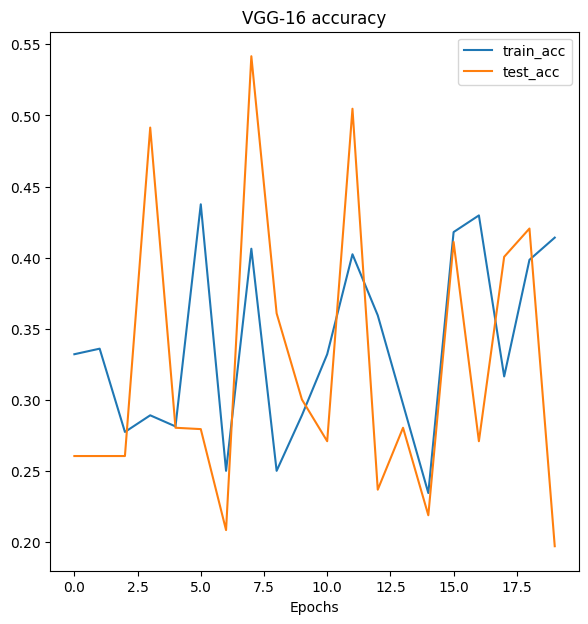

In [17]:
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), new_model_score["train_acc"], label = "train_acc")
plt.plot(range(epochs), new_model_score["test_acc"], label = "test_acc")
plt.title("VGG-16 accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()